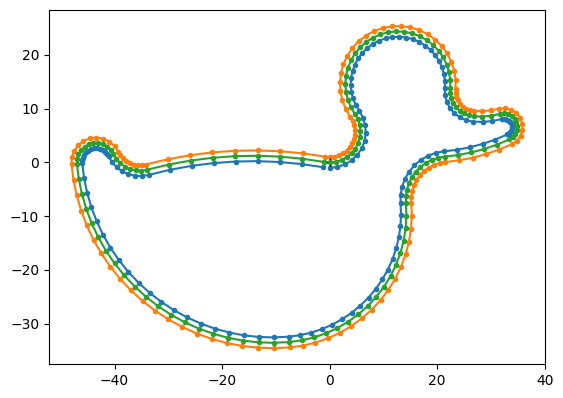

135

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign
deg=pi/180
PlainSegments=[(50,360*deg)]
ScallopedSegments=[s for n,a in ((9,150),) for S in (((1.0,(360/n-a)*deg),(2,a*deg)),)for _ in range(n) for s in S]
HeartSegments=[(0.45,-45.0*deg),(10.0,180.0*deg),(6.91,-10.0*deg),(1.1,110.0*deg),(6.91,-10.0*deg),(10.0,180.0*deg),(0.45,-45.0*deg)]
StarSegments=[s for n,a in ((5,130.0,),) for _ in range(n) for s in ((2,-(a-360/n)*deg),(8,0.0),(3.2,a*deg),(8,0.0),)]
DuckSegments=[(0.4,-10.0*deg),(13.297,25.0*deg),(3,-80.0*deg),(4,160.0*deg),(22.913,90.0*deg),(15,90.0*deg),(5,-90.0*deg), (5,20.0*deg),(3,170.0*deg),(2,-20.0*deg),(3,-90.0*deg),(15,220.0*deg),(5,-125.0*deg),]
TreeSegments=[(0.75,40.0/180*pi)]+[s for n,a in ((4,140),) for _ in range(n) for s in ((3,0.0), (1.5,a*deg),(0.6,0.0), (1.0,-a*deg))][:-3]+[(1.5,140.0*deg)]
TreeSegments+=[(12.4-0.969,0)]
TreeSegments+=reversed(TreeSegments[:-1])

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLengthArea(Segs):
  nSegs=len(Segs)
  dl,dang=np.array(Segs).transpose()
  l=sum(dl)
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return l,area

def InterpSegments(Segs,t,p0=0+0j,a0=1+0j,scale=1.0,return_heading=False):
  dl,dang=np.array(Segs).transpose()
  l,ang=np.cumsum(Segs,axis=0).transpose()
  ang=exp(1j*np.insert(ang,0,0))*a0
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(viSeg)+p0
  l=l/l[-1]
  l=np.insert(l,0,0)
  Xx=np.interp(np.array(t)%1,l,range(len(l)))
  X=Xx.astype(int)#segment index
  x=Xx%1#within seggment
  p=pSeg[X-1] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  if not return_heading:
    return p
  else:
    a=ang[X]*np.exp(1j*dang[X]*x)
    return p,a

def Segments2Complex(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,return_heading=False):
  a=a0
  p=p0
  p-=1j*a*offs
  for l,da in Segs:
    l=l*scale
    if da!=0:
      r=l/da
      r+=offs
      dl=2*abs(2*r*tol)**0.5
      n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
      dda=exp(1j*da/n)
      dda2=dda**0.5
      v=(2*r*dda2.imag)*dda2*a
    else:
      n=1
      dda=1
      v=l*a
    for _ in range(n):
      p+=v
      if return_heading:
        yield p,a
      else:
        yield p
      v*=dda
      a*=dda

for offs in (-1,1,0):
  px,a=np.array(list(Segments2Complex(DuckSegments,scale=2.5,a0=-1,tol= 0.03,offs=offs,return_heading=True))).transpose()
#  x-=1j*a*offs
  plt.plot(0,0,'k+')
  plt.plot(px.real,px.imag,'.-')
plt.gca().set_aspect('equal')
plt.show()
len(px)

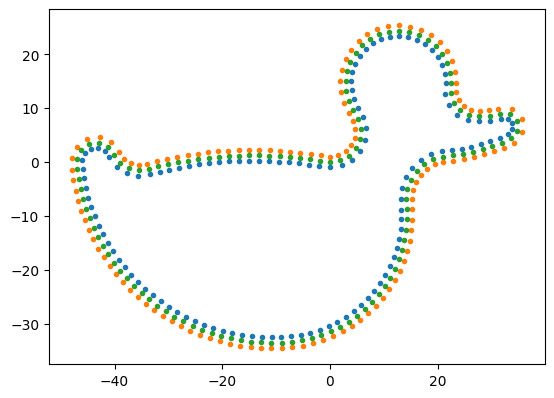

In [2]:
n=128
t=np.arange(0,1-0.5/n,1/n)#equally spaced
p,a=InterpSegments(DuckSegments,t,a0=-1,scale=2.5,return_heading=True)
for offs in (-1,1,0):
  p1=p-1j*offs*a
  plt.plot(p1.real,p1.imag,'.')
plt.gca().set_aspect('equal');

In [3]:
def fill(minx,maxx,n):
  w=maxx-minx
  dx=float(w)/n
  x=minx+dx/2
  result=[(x,dx)]
  for i in range(n-1):
    x+=dx
    result.append((x,dx))
  if n>3:
    result=[result[1]]+[result[0]]+result[n-2:]+result[2:n-2]
  return result
Brickwork= [fill(-w2,w2,n) for w2,n in ((3.6/2,4),(4.0/2,5),(4.4/2,6),(4.6/2,5))]+ \
      [((0.0,cw),(-w2+ww/2,ww),(w2-ww/2,ww)) for w2,ww,cw in[ \
        (4.8/2,1.0,1.0),\
        (5.0/2,1.0,0.8),\
        (5.0/2,0.9,0.6)]+\
        [(5.0/2,0.9,0.5)]*2+[\
        (4.8/2,0.9,0.5),\
        (4.6/2,0.9,0.5),\
        (4.4/2,1.0,0.5)]+\
        [(w2,1.0,0.5)for w2 in(4.0/2,3.6/2,3.2/2,2.8/2)]+\
        [(2.4/2,0.9,0.6)]
        ]+\
      [fill(-w2,w2,n) for w2,n in ((2.0/2,2),(1.6/2,3),(1.2/2,2))]+\
      [[(0.0,1.0-0.5*i/50.0)] for i in range(50+1)]


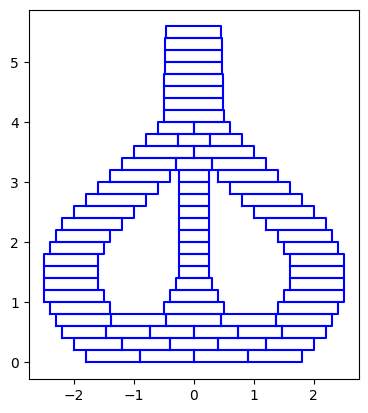

In [4]:
hl=0.2
for i,layer in enumerate(Brickwork):
    y=i*hl
    if y>5.5:
      break
    for x,w in layer:
      plt.plot((x-w/2,x+w/2,x+w/2,x-w/2,x-w/2),(y,y,y+hl,y+hl,y),'b-')
plt.gca().set_aspect('equal')

In [5]:
if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
from math import cos, tau

No module named 'fullcontrol'
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
steps=[]
Segments=DuckSegments
_,A=SegmentsLengthArea(Segments)
CookieArea=2000
hl=0.2
scale=(CookieArea/A)**0.5
print(scale)
tol=0.03
x0,y0=20,20
nwipe=5
nskip=10
jt=0
for i,layer in enumerate(Brickwork):
    if len(layer)==1:#start of cutting blade: do spiral instead of layers
      break
    z=i*hl
    for offs,w in layer:
      path=list(Segments2Complex(Segments,p0=x0+1j*y0,a0=-1,tol=tol,scale=scale,offs=offs))
      n=len(path)
      steps.append(fc.Extruder(on=False))
      steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=hl,width=w))
      jt=jt%n
      p=path[jt]
      steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
      for _ in range(nskip):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=True))
      for _ in range(n):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=False))
      for _ in range(nwipe):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
path=list(Segments2Complex(Segments,p0=x0+1j*y0,a0=-1,tol=tol,scale=scale,offs=offs))
n=len(path)
zb=z
zt=zb+10
dzdj=hl/n
w=layer[0][1]
#print(w)
dwdj=(w-Brickwork[-1][0][1])/(n*(zt-zb)/hl)
old_eh=-1
old_w=-1
steps.append(fc.Extruder(on=True))
#while False:
while  z<(zt+hl):
  jt=(jt+1)%n
  z+=dzdj
  w-=dwdj
  eh=min(z-zb,zt-(z-hl),hl)
  p=path[jt]
  if (abs(eh-old_eh)/hl)>0.01 or abs(w-old_w)>0.005:
   # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
    steps.append(fc.ExtrusionGeometry(area_model='rectanle',height=eh,width=w))
    old_eh=eh
    old_w=w
  steps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=0, y=0, z=0.8*hl)
#print(f'{w=} {eh=}')
steps = fc.move(steps, model_offset)

2.3929260091125077


In [7]:
# add annotations and plot
EW=1.0
EH=0.2
fc.transform(steps, 'plot', fc.PlotControls(color_type='print_sequence', initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

Output hidden; open in https://colab.research.google.com to view.